# Introduction

we need to get data for the DPS proposal HK.




In [ ]:
# load packages
from math import sin, cos, sqrt, atan2, radians
#import folium
#from folium import FeatureGroup, LayerControl
#from folium.plugins import TimestampedGeoJson
#from folium import plugins
import json
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.io import gbq
from google.cloud import bigquery
#import geopandas
from shapely import wkt
%matplotlib inline
from google.colab import drive # to allow colab save file in my drive
drive.mount('/content/drive')
from google.colab import auth
auth.authenticate_user()
print('Authenticated')
cwd=os.getcwd()
cwd
%unload_ext google.colab.data_table

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
Authenticated
The google.colab.data_table extension is not loaded.


In [ ]:
# define project id
project_id = "fulfillment-dwh-production"
client = bigquery.Client(project = project_id)

In [ ]:
%cd "/content/drive/Shared drives/Global Pricing/2 - Entities/Foodpanda/HK Foodpanda"
%pwd
%ls

#load pandora data
#path = "/content/drive/My Drive/dataset (1)/hk_pandora.csv"
#pandora = pd.read_csv(path)


/content/drive/Shared drives/Global Pricing/2 - Entities/Foodpanda/HK Foodpanda
'1 - DBDF and MOV Tests 201907'/   Analysis/
'2 - DBDF proposal 20200330'/      DPS/


## Calculating Travel Time

In [ ]:
query1 = """

select
o.platform_order_code,
z.name zone_name,
z.id zone_id,
vendor.id vendor_id,
vendor.vendor_code vendor_code,
vendor.name vendor_name,
cast(o.order_placed_at as date) order_date,
p.drive_time_value,
st_distance(vendor.location,customer.location) as st_distance
from fulfillment-dwh-production.cl.orders o
left join unnest(deliveries) d
left join unnest(porygon) p
left join cl.countries on o.country_code = countries.country_code
left join unnest(cities) c on c.id = o.city_id
left join unnest(zones) z on z.id = o.zone_id
where
o.country_code = 'hk'
and o.order_status = 'completed'
and d.delivery_status = 'completed'
and o.created_date between '2020-04-27' and '2020-05-17'
and p.vehicle_profile = 'default'

"""

bigquery = client.query(query1).to_dataframe()
bigquery.head()

,platform_order_code,zone_name,zone_id,vendor_id,vendor_code,vendor_name,order_date,drive_time_value,st_distance
0,s2mg-8jbq,Wan chai cwb walker,38.0,507,s2mg,Chrisly Cafe (Wan Chai),2020-05-16,4,511.895328
1,x7tt-qp5z,Aberdeen rider,20.0,21993,x7tt,Itamomo (Aberdeen),2020-05-16,30,1369.392546
2,v9tc-92p4,Tseung kwan o rider,10.0,12817,v9tc,Maxim's MX (PopWalk 3),2020-05-16,18,1384.184886
3,v1di-efjt,To kwa wan rider,56.0,13122,v1di,The Farm Cafe (To Kwa Wan),2020-05-16,6,741.826010
4,x9ts-228i,Tst walker,22.0,23624,x9ts,Tao Heung (Tsim Sha Tsui Minden Row),2020-05-16,6,273.849826


In [ ]:
# DPS distance calculation formula (offered by Daniel)

"""
private double calculateDistance(Coordinate origin, Coordinate destination) {
        double lat1Rad = Math.toRadians(origin.getY());
        double lat2Rad = Math.toRadians(destination.getY());
        double lngDiffRad = Math.toRadians(origin.getX() - destination.getX());
        double latDiffRad = Math.toRadians(origin.getY() - destination.getY());
        double result = Math.sin(latDiffRad / 2) * Math.sin(latDiffRad / 2)
                + Math.cos(lat1Rad) * Math.cos(lat2Rad) * Math.sin(lngDiffRad / 2) * Math.sin(lngDiffRad / 2);
        return 2 * Math.atan2(Math.sqrt(result), Math.sqrt(1 - result)) * EARTH_RADIUS;
    }
"""

# calculation and comparison with st_distance results
"""
df["vendor_lat1"] = np.radians(df["vendor_lat"])
df["customer_lat1"] = np.radians(df["customer_lat"])
df["dlon"] = np.radians(df["customer_long"] - df["vendor_long"])
df["dlat"] = np.radians(df["customer_lat"] -df["vendor_lat"])
df["helper"] = np.sin(df["dlat"] / 2)*np.sin(df["dlat"] / 2) + np.cos(df["vendor_lat1"]) * np.cos(df["customer_lat1"]) * np.sin(df["dlon"] / 2) * np.sin(df["dlon"] / 2)
df["cal_distance"] = 2 * np.arctan2(np.sqrt(df["helper"]), np.sqrt(1 - df["helper"]))*6371*1000

df["diff_distance"] = df["cal_distance"] - df["st_distance"]

"""

In [ ]:
df = bigquery.copy()
# formula: 0.44726706619783857x (x in meter, output in second)
# formula transformation: 7.454451103x (x in km, output in minutes)
df["travel_time"] = 7.454451103*df["st_distance"]/1000 
df["travel_time_floor"] = df["travel_time"].apply(np.floor)
df.head()

,platform_order_code,zone_name,zone_id,vendor_id,vendor_code,vendor_name,order_date,drive_time_value,st_distance,travel_time,travel_time_floor
0,w3wv-thvr,Stanley rider,28,21169,w3wv,Verde by Cali-Mex (Stanley),2020-04-23,18,2400.311776,17.893007,17.0
1,w8na-1xb6,Kowloon bay rider,3,21446,w8na,Food Chillax,2020-04-23,10,1785.524479,13.310105,13.0
2,w5jd-zrfs,Tuen mun walker,41,22206,w5jd,McDonald’s (Wah Lok),2020-04-23,4,291.637807,2.174000,2.0
3,v3mz-91ut,Tuen mun rider,33,14849,v3mz,Soup Queen (Tuen Mun),2020-04-23,10,1620.045602,12.076551,12.0
4,w1ek-6td2,Aberdeen rider,20,13606,w1ek,Yu Mai (Wah Kwai Centre),2020-04-23,6,337.420473,2.515284,2.0


In [ ]:
"""
#load pandora data
path = "/content/drive/Shared drives/Global Pricing/2 - Entities/Foodpanda/HK Foodpanda/hk_pandora_april.csv"
pandora = pd.read_csv(path)

df_new = pd.merge(df,
              pandora,
              left_on = "platform_order_code",
              right_on = "order_code_google",
              how = "left")

df_new.to_csv('hk_tt_threshold.csv')
!cp hk_tt_threshold.csv "/content/drive/Shared drives/Global Pricing/2 - Entities/Foodpanda/HK Foodpanda/"
"""

In [ ]:
#pivot=df.pivot_table("platform_order_code", index=['drive_time_value',"zone_name", "zone_id"], aggfunc='count')
#pivot
#pivot.to_csv('porygon_zone.csv')
#!cp porygon_zone.csv "/content/drive/Shared drives/Global Pricing/2 - Entities/Foodpanda/HK Foodpanda/"

In [ ]:
pivot1 = df.groupby("drive_time_value")["platform_order_code"].count()
pivot2 = df.groupby("travel_time_floor")["platform_order_code"].count()

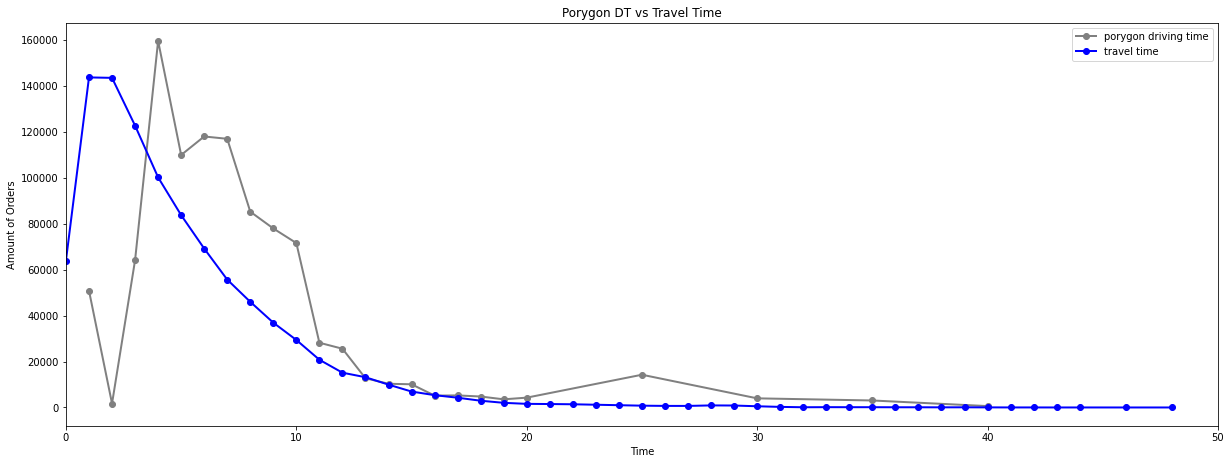

In [ ]:
fig = plt.figure(figsize=(20,7))
axes = fig.add_axes([0.1,0.1,0.8,0.8])

axes.plot(pivot1, label = "porygon driving time", color = "gray", lw = 2, marker = "o") # color RGB Hex Code, alpha = transparency level
axes.plot(pivot2, label = "travel time", color = "blue", lw = 2, marker = "o") # linestype
axes.set_xlabel("Time")
axes.set_ylabel("Amount of Orders")
axes.set_title("Porygon DT vs Travel Time")
plt.xlim(0,50)

axes.legend(loc=0)

#zooming
#axes.set_xlim([0,1])
#axes.set_ylim([0,1])


In [ ]:
#load pandora data
path = "/content/drive/Shared drives/Global Pricing/2 - Entities/Foodpanda/HK Foodpanda/hk_pandora_april.csv"
pandora = pd.read_csv(path)

In [ ]:
df = pd.merge(bigquery,
              pandora,
              left_on = "platform_order_code",
              right_on = "order_code_google",
              how = "left")

In [ ]:
df_new = pd.read_excel('hk_sample.xlsx')  

In [ ]:
df_new.columns = ['order_id',"zone_name",'delivery_distance','drive_time',"created_date", "travel_time_tbd","travel_time", "current_delivery_fee"]
df_new = df_new.drop(["travel_time_tbd"], axis=1)
df = df_new
df.head()

,order_id,zone_name,delivery_distance,drive_time,created_date,travel_time,current_delivery_fee
0,x6lo-55wa,Mongkok walker,0,4,2020-04-25,0.00000,5
1,v1jv-8e46,Mongkok walker,0,1,2020-04-21,0.00000,5
2,w6xk-r6v8,Mongkok walker,0,1,2020-04-21,0.00000,5
3,w8gs-vtkq,Mongkok rider,1786,9,2020-04-25,13.31365,20
4,x6lo-7xja,Mongkok walker,0,4,2020-04-21,0.00000,5


In [ ]:
df["travel_time"]

0         0.000000
1         0.000000
2         0.000000
3        13.313650
4         0.000000
           ...    
48786     3.563228
48787     7.238272
48788     4.196856
48789     4.196856
48790     4.196856
Name: travel_time, Length: 48791, dtype: float64

In [ ]:
df[df['order_id'] == "v1jv-8e46"]

,order_id,zone_name,delivery_distance,drive_time,created_date,travel_time,current_delivery_fee
1,v1jv-8e46,Mongkok walker,0,1,2020-04-21,0.0,5


In [ ]:
df.iloc[[2]]["current_delivery_fee"]
df.at[0,'zone_name']

'Mongkok walker'

In [ ]:
df_mongkok = df[df["zone_name"] == "Mongkok rider"]
df_mongkok.head()

,order_id,zone_name,delivery_distance,drive_time,created_date,travel_time,current_delivery_fee
3,w8gs-vtkq,Mongkok rider,1786,9,2020-04-25,13.313650,20
6,w8gs-ww8q,Mongkok rider,1030,6,2020-04-25,7.678085,15
10,w2ol-wcnh,Mongkok rider,1072,8,2020-04-25,7.991172,20
13,w8gs-d5kl,Mongkok rider,898,8,2020-04-25,6.694097,20
16,w8gs-54h8,Mongkok rider,1778,9,2020-04-25,13.254014,20


In [ ]:

df_monkok_sorted = df_mongkok.sort_values(by=['travel_time'])
tiers = df_monkok_sorted['current_delivery_fee'].unique().tolist()
tiers.sort()
len(df_monkok_sorted.head())

number_of_orders_total = len(df_monkok_sorted)
number_of_orders_per_tier = []
fractions_of_orders_per_tier = []
fractions_of_orders_per_tier_accumulated = []
fraction_of_orders_per__current_tier = 0
treshold_index = 0
thresholds = []


for tier in tiers:
  print(tier)
  number_of_orders_per_current_tier = len(df_monkok_sorted.loc[df_monkok_sorted['current_delivery_fee'] == tier])
  fraction_of_orders_per__current_tier = number_of_orders_per_current_tier / number_of_orders_total
  fractions_of_orders_per_tier.append(fraction_of_orders_per__current_tier)
  number_of_orders_per_tier.append(number_of_orders_per_current_tier)
  if len(fractions_of_orders_per_tier) == 1:
    fractions_of_orders_per_tier_accumulated.append(fractions_of_orders_per_tier[len(fractions_of_orders_per_tier)-1])
  else:
    fractions_of_orders_per_tier_accumulated.append(fractions_of_orders_per_tier_accumulated[len(fractions_of_orders_per_tier)-2] + fractions_of_orders_per_tier[len(fractions_of_orders_per_tier)-1])
  treshold_index = number_of_orders_total * fraction_of_orders_per__current_tier
  thresholds.append(df_monkok_sorted.travel_time.quantile(fractions_of_orders_per_tier_accumulated[len(fractions_of_orders_per_tier_accumulated)-1]))
  print(treshold_index)



number_of_orders_per_tier
print(fractions_of_orders_per_tier)
print(fractions_of_orders_per_tier_accumulated)
thresholds

5
170.0
15
1078.0
20
2314.0
25
303.0
[0.04398447606727038, 0.27891332470892627, 0.5987063389391979, 0.07839586028460543]
[0.04398447606727038, 0.3228978007761967, 0.9216041397153946, 1.0]


[3.3917752520002717, 8.11789725149076, 13.643398713355637, 22.3708077609952]